# Data Exploration: IMDb Movie Reviews Dataset

## Overview

The IMDb dataset contains 50,000 movie reviews labeled as positive (1) or negative (0). This is a classic binary sentiment classification task that allows us to compare classical ML and deep learning approaches.

## Dataset Characteristics

- **Source**: Stanford AI Lab
- **Task**: Binary sentiment classification
- **Samples**: 50,000 reviews (25,000 train, 25,000 test)
- **Classes**: Positive (1) and Negative (0)
- **Text Length**: Variable (typically 100-2000 words per review)

## Why This Dataset?

1. **Standard Benchmark**: Widely used in NLP research
2. **Clear Task**: Binary classification is interpretable
3. **Real-world Relevance**: Sentiment analysis has practical applications
4. **Text Complexity**: Reviews contain varied vocabulary and style
5. **Size**: Large enough to demonstrate scalability differences between approaches


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


2025-12-14 06:13:55.813834: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-14 06:13:57.436467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-14 06:14:02.426138: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Load IMDb dataset
# num_words: keep top 10,000 most frequent words
# skip_top: skip most frequent words (often stopwords)
# maxlen: maximum sequence length (None = no limit)
print("Loading IMDb dataset...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000, skip_top=0, maxlen=None)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nLabel distribution (training):")
print(f"  Positive (1): {np.sum(y_train == 1)}")
print(f"  Negative (0): {np.sum(y_train == 0)}")


Loading IMDb dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training samples: 25000
Test samples: 25000
Training labels shape: (25000,)
Test labels shape: (25000,)

Label distribution (training):
  Positive (1): 12500
  Negative (0): 12500


In [3]:
# Get word index mapping
word_index = imdb.get_word_index()
# Reverse mapping: word_index -> word
reverse_word_index = {value: key for (key, value) in word_index.items()}

# Decode a review to see what it looks like
def decode_review(encoded_review):
    """Decode an encoded review back to text."""
    # Word indices are offset by 3 (0: padding, 1: start, 2: unknown)
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

# Show example reviews
print("Example Positive Review (first 500 chars):")
print(decode_review(X_train[0])[:500])
print("\n" + "="*80)
print("Example Negative Review (first 500 chars):")
print(decode_review(X_train[np.where(y_train == 0)[0][0]])[:500])


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Example Positive Review (first 500 chars):
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to ever

Example Negative Review (first 500 chars):
? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how 

/tmp/ipykernel_6902/2334615601.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([train_lengths, test_lengths], labels=['Train', 'Test'])


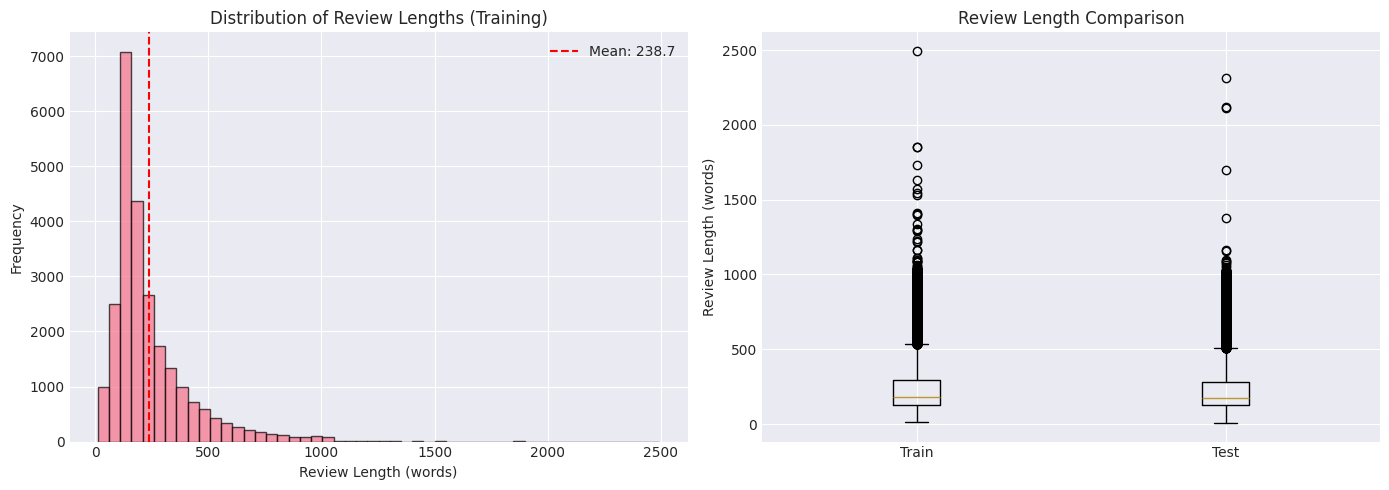

Training set statistics:
  Mean length: 238.7 words
  Median length: 178.0 words
  Min length: 11 words
  Max length: 2494 words

Test set statistics:
  Mean length: 230.8 words
  Median length: 174.0 words


In [4]:
# Analyze review lengths
train_lengths = [len(review) for review in X_train]
test_lengths = [len(review) for review in X_test]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Review Length (words)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Review Lengths (Training)')
axes[0].axvline(np.mean(train_lengths), color='red', linestyle='--', 
               label=f'Mean: {np.mean(train_lengths):.1f}')
axes[0].legend()

axes[1].boxplot([train_lengths, test_lengths], labels=['Train', 'Test'])
axes[1].set_ylabel('Review Length (words)')
axes[1].set_title('Review Length Comparison')

plt.tight_layout()
plt.show()

print(f"Training set statistics:")
print(f"  Mean length: {np.mean(train_lengths):.1f} words")
print(f"  Median length: {np.median(train_lengths):.1f} words")
print(f"  Min length: {np.min(train_lengths)} words")
print(f"  Max length: {np.max(train_lengths)} words")
print(f"\nTest set statistics:")
print(f"  Mean length: {np.mean(test_lengths):.1f} words")
print(f"  Median length: {np.median(test_lengths):.1f} words")


In [5]:
# Convert to text format for classical ML approach
# We'll save both encoded and text versions
def convert_to_text(encoded_reviews):
    """Convert encoded reviews to text strings."""
    texts = []
    for review in encoded_reviews:
        texts.append(decode_review(review))
    return texts

# For classical ML, we'll use a subset for faster processing
# Full dataset can be used, but we'll use 10,000 samples for demonstration
n_samples_classical = 10000

# Sample indices
train_indices = np.random.choice(len(X_train), n_samples_classical, replace=False)
test_indices = np.random.choice(len(X_test), min(n_samples_classical, len(X_test)), replace=False)

# Convert to text
X_train_text = [decode_review(X_train[i]) for i in train_indices]
X_test_text = [decode_review(X_test[i]) for i in test_indices]
y_train_classical = y_train[train_indices]
y_test_classical = y_test[test_indices]

print(f"Classical ML dataset:")
print(f"  Training: {len(X_train_text)} samples")
print(f"  Test: {len(X_test_text)} samples")

# Save for use in other notebooks
import pickle

data_dict = {
    'X_train_text': X_train_text,
    'X_test_text': X_test_text,
    'y_train_classical': y_train_classical,
    'y_test_classical': y_test_classical,
    'X_train_encoded': X_train,
    'X_test_encoded': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'word_index': word_index
}

with open('../imdb_data.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

print("\nData saved to '../imdb_data.pkl'")


Classical ML dataset:
  Training: 10000 samples
  Test: 10000 samples

Data saved to '../imdb_data.pkl'
